**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***


<p align="center">
<img src="media/agents_header.png" alt="LLM" width="800"/> <br>
Image from TrueFoundry's "<i><a href="https://www.truefoundry.com/blog/llm-agents">What are LLM Agents?</a></i>". <br>Copyright © 2025. All rights reserved.
</p>

***
Sources: <br>
- [What are LLM Agents? (TrueFoundry)](https://www.truefoundry.com/blog/llm-agents)
- [What is an AI Agent? (LangChain)](https://blog.langchain.dev/what-is-an-agent/)


# LLM agents

Think about how we have used LLMs so far: We have given an LLM a single task. It's easy to consider that we could *chain* these tasks together to create a more complex system. For example, we could ask a language model to generate a summary of a text, and then - in a separate step - ask it to classify the sentiment of the summary. This is what we call *chaining* of LLM tasks. In chains, a sequence of actions is hardcoded (in code). In agents, a language model is used as a *reasoning engine* to determine which actions to take and in which order. In other words, an AI agent is a system that uses an LLM to decide the control flow of an application, instead of having it hardcoded. 

An LLM Agent will

1. Receive a sensory input (e.g. a text)
2. Decide what to do with it
3. Take an action (e.g. generate a summary)

Let's think about the implications of this for a moment. If we can get an LLM to consider a task and then decide for itself how best to solve it, we are approaching a very human-like way of thinking.

### What does it mean to be agentic?

<p align="center">
<img src="media/levels-of-agentic.png" alt="LLM" width="800"/> <br>
Image from LangChain's "<i><a href="https://blog.langchain.dev/what-is-an-agent/">What is an AI agent?</a></i>" by Harrison Chase, CEO of LangChain AI. <br>Copyright © 2025. All rights reserved.
</p>

According to Harisson Chase, a system is more “agentic” the more an LLM decides how the system can behave.

| Level of Agentic Behavior                                                                 | Description                                                                                                                                                     |
|------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Router                                                                                   | Using an LLM to route inputs into a particular downstream workflow has some small amount of “agentic” behavior. This would fall into the `Router` category.       |
| Between Router and State Machine                                                        | If you use multiple LLMs to do multiple routing steps, this would be somewhere between `Router` and `State Machine`.                                                |
| State Machine                                                                            | If one of those steps is determining whether to continue or finish - effectively allowing the system to run in a loop until finished, it would fall into this category. |
| Autonomous Agent                                                                         | If the system is building tools, remembering those, and then taking those in future steps, it is incredibly agentic, similar to what the [Voyager paper](https://arxiv.org/abs/2305.16291) implemented. |

### Agents as graph-based systems

<p align="center">
<img src="media/graph.png" alt="LLM" width="800"/> <br>
Image from Ionio "<i><a href="https://www.ionio.ai/blog/a-comprehensive-guide-about-langgraph-code-included">A Comprehensive Guide About Langgraph</a></i>". <br>by Shivam Danawale and Pranav Patel<br>
Copyright © 2025. All rights reserved.
</p>

Following the image above, we see that the workflow is triggered by an input from a user. Next, we hit the first node, likely an LLM. This LLM provides an output - not back to the user but to the next nodes, routed via *conditional edges*. In other words, the LLM (our the output of the latest LLM node) will determine which route we will take to answer the query - or carry out the associated task. We can repeat this process for downstream nodes. Eventually, we will end in an *END* node - or we might even return to the first node again and start over!

***

### Agents in LangGraph

We will be using *LangGraph* to create a simple `router` agent system in this notebook. [LangGraph](https://langchain-ai.github.io/langgraph/) is a graph-based system that allows us to create complex workflows using LLMs. A couple of key concepts in LangGraph are:

| Concept  | Description |
|---------------| ------|
| **State**     | State is the central concept in LangGraph. It represents all the information that flows through your application. |
| **Node**      | A node is a single unit of computation - just like neurons in neural networks. In LangGraph, nodes are Python functions. For example, Nodes can contain LLM calls (Generate text or make decisions), Tool calls (Interact with external systems), Conditional logic (Determine next steps), Human intervention (Get input from users). Some nodes necessary for the whole workflow like `START` and `END` exist from LangGraph directly. |
| **Edges**     | Edges connect nodes and define the possible paths through your graph. |
| **StateGraph**| The StateGraph is the container that holds your entire agent workflow. |

LangChain has released an excellent [introduction to these concepts here](https://huggingface.co/learn/agents-course/unit2/langgraph/building_blocks)







### Setup

In this notebook, we will be using *LangGraph* to create a simple `router` agent system. LangGraph is a graph-based system that allows us to create complex workflows using LLMs. 

In [ ]:
# built-in libraries
from typing import Literal, TypedDict,  Any, Optional

# langgraph libraries
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.graph import  MermaidDrawMethod

# misc libraries
from pydantic import Field
from IPython.display import Image
from decouple import config
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from tqdm import tqdm
from sklearn.metrics import f1_score

# local modules
from src.llm import LLMCaller

Let's start by loading our WatsonX.ai credentials again

In [2]:
WX_API_KEY = config("WX_API_KEY")
WX_PROJECT_ID = config("WX_PROJECT_ID")
WX_API_URL = "https://us-south.ml.cloud.ibm.com"

We can call out neat `LLMCaller` class, defined in `src/llm.py::LLMCaller`, to use `litellm` and `instructor` in a single class. Please check out [guides/instructor_guide.ipynb](instructor_guide.ipynb) for more information on how to use this class.

In [35]:
model = LLMCaller(
    api_key=WX_API_KEY,
    project_id=WX_PROJECT_ID,
    api_url=WX_API_URL,
    model_id="watsonx/ibm/granite-3-2-8b-instruct",
    params={
        GenParams.TEMPERATURE: 0.7,
        GenParams.MAX_NEW_TOKENS: 300,
    }
)

In [36]:
response = model.invoke(prompt="Write a haiku about a fish")

response

BaseResponse(answer="Fish in stream gleams,\nSilent, swift, in watery dreams, \nNature's poetic themes.")

***

# A simple AI agent

We will build a simple `router` AI agent system: A chatbot - Mailbot, who

1. Reads incoming emails
2. Classifies them into a list of categories
3. Decides whether they are spam or not
4. If they are not spam, he will draft a suitable response
5. If they are spam, he will move the email to the spam folder. 

First, we need to define our `State`. To reiterate, this is the central concept in LangGraph and represents all the information that flows through our application.

All these attributes will be populated as we run the agent system.

In [37]:
class EmailState(TypedDict):

    email: dict[str, Any]  # The email being processed - Contains subject, sender, body, etc.
    email_category: Optional[str]  # Category of the email (e.g., work, personal, etc.
    spam_reason: Optional[str]  # Reason for categorizing the email as spam
    is_spam: Optional[bool]  # Whether the email is deemed to be spam or not
    draft: Optional[str]  # Draft response to the email
    verbose : bool = False  # Whether to provide verbose output

Now let's define our *nodes* - the python functions that make up the system.

In [38]:
# Initialize our LLM
def read_email(state: EmailState):
    """Mailbot reads and logs the incoming email"""
    email = state["email"]  # Extract the email from the state
    
    if state["verbose"]:
        print(f"Mailbot is processing an email from {email['sender']} with subject: {email['subject']}")
    
    # No state changes needed here
    return {} # <- if we don't need to update the state, we return an empty dictionary

def classify_email(state: EmailState):
    """Mailbot uses an LLM to determine if the email is spam or legitimate"""
    email = state["email"]  # Extract the email from the state
    
    # Prepare our prompt for the LLM
    prompt = f"""Analyze this email and determine if it is spam or legitimate.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    First, determine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).
    """
    
    # Create our response model
    response_model = model.create_response_model(
        "EmailAnalysis", 
        {
            "spam_reason": (str, Field(description="The reasoning behind the decision.")),
            "is_spam": (bool, Field(description="Whether the email is spam.")),
            "email_category": (Literal["Transactional", "Marketing", "Relational", "Administrative", "Security/alert", "Spam"], Field(description="The category of the email.")) 
        }
    )

    # Call the LLMCaller with the prompt and response model
    response = model.invoke(prompt, response_model=response_model)

    # Extract the response data
    is_spam = response.is_spam
    spam_reason = response.spam_reason
    email_category = response.email_category
    
    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
    }

def handle_spam(state: EmailState):
    """Mailbot discards spam email with a note"""

    if state["verbose"]:
        print(f"Mailbot has identified the email as spam. Reason: {state['spam_reason']}")
        print("The email has been moved to the spam folder.")
    
    # We're done processing this email
    return {}

def draft_response(state: EmailState):
    """Mailbot drafts a preliminary response for legitimate emails"""
    email = state["email"]  # Extract the email from the state
    category = state["email_category"] or "general"  # Default to a general category if not specified
    
    # Prepare our prompt for the LLM
    prompt = f"""Draft a polite preliminary response to this email.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    This email has been categorized as: {category}
    
    Draft a brief, professional response that your employer can review and personalize before sending.
    """
    
    # Call the LLM - this time without a custom response model
    response = model.invoke(prompt) # we can use the default response model here
    answer = response.answer  # Extract the response from the LLM

    # Return state updates
    return {"draft": answer}  # add the draft response to the state

def notify(state: EmailState):
    """Mailbot notifies its employer about the email and presents the draft response"""
    email = state["email"]  # Extract the email from the state
    
    if state["verbose"]:
        # some pretty printing to emulate the notification
        print("\n" + "="*50)
        print(f"Hi boss, you've received an email from {email['sender']}.")
        print(f"Subject: {email['subject']}")
        print(f"Category: {state['email_category']}")
        print("\nI've prepared a draft response for your review:")
        print("-"*50)
        print(state["draft"])
        print("="*50 + "\n")
    
    # We're done processing this email
    return {}

Next, let's create our *conditional edge* - the logic that decides which path to take based on the output of the LLM.

In [39]:
def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state["is_spam"]: # If the email is spam, meaning "is_spam" is True
        return "spam" # Move to the spam handling step
    else:
        return "legitimate"  # Move to the legitimate email handling step

Now we have our `State` and our `nodes`, we need our edges - the connections between the nodes that define the possible paths through our graph.

First, we can create our `StateGraph` - the container that holds our entire agent workflow. Then we add nodes and edges to it.

In [40]:
# Create the graph
email_graph = StateGraph(EmailState)  # Initialize the graph with the EmailState state

# Add nodes
email_graph.add_node("read_email", read_email)  # Add the read_email node
email_graph.add_node("classify_email", classify_email)  # Add the classify_email node
email_graph.add_node("handle_spam", handle_spam)  # Add the handle_spam node
email_graph.add_node("draft_response", draft_response)  # Add the draft_response node
email_graph.add_node("notify", notify)  # Add the notify node

In [41]:

# Start the edges - LangGraph requires a start node
email_graph.add_edge(START, "read_email")  # Start with reading the email
# Add edges - defining the flow
email_graph.add_edge("read_email", "classify_email")  # After reading, classify the email

# Add conditional branching from classify_email
email_graph.add_conditional_edges(
    "classify_email",
    route_email, # based on this function..
    {
        "spam": "handle_spam",  # .. we route to these nodes
        "legitimate": "draft_response"
    }
)

# Add the final edges
email_graph.add_edge("handle_spam", END)  # End the process after handling spam
email_graph.add_edge("draft_response", "notify")  # if not spam, we draft a response..
email_graph.add_edge("notify", END) # .. and notify us - END

# Compile the graph
compiled_graph = email_graph.compile()  # Compile the graph

Visualize our graph

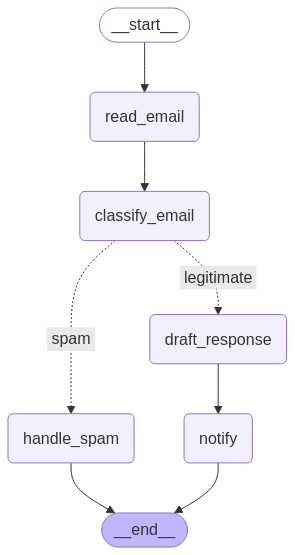

In [42]:
Image(compiled_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API))

## Test our system

In [43]:
# Example legitimate email
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Valentino, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

# Example spam email
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

In [44]:

# Process the legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke(
    {
        "email": legitimate_email, # invoke the graph with the email
        "verbose": True,  # enable verbose output
    }
)


Processing legitimate email...
Mailbot is processing an email from john.smith@example.com with subject: Question about your services

Hi boss, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: Relational

I've prepared a draft response for your review:
--------------------------------------------------
Dear Mr. Smith,

Thank you for reaching out and your interest in our consulting services.
I appreciate the opportunity to provide more information and discuss how we might be able to assist you.
Forgive the slight delay, as I am currently away from the office and unable to schedule meetings directly.
I would be delighted to have a call with you next week to further explore potential collaboration.
Please let me know your availability, and I will do my best to accommodate it.

Best regards,
[Your Name]
[Your Position]
[Your Contact Information]



The output of our system is a `State` object. We can use this to check if our system is working as expected and use the data downstream in our application.

In [45]:
legitimate_result

{'email': {'sender': 'john.smith@example.com',
  'subject': 'Question about your services',
  'body': "Dear Mr. Valentino, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"},
 'email_category': 'Relational',
 'spam_reason': 'The email does not contain any suspicious links, requests for personal information, or promotional content. It is a direct inquiry about consulting services from a referred contact.',
 'is_spam': False,
 'draft': 'Dear Mr. Smith,\n\nThank you for reaching out and your interest in our consulting services.\nI appreciate the opportunity to provide more information and discuss how we might be able to assist you.\nForgive the slight delay, as I am currently away from the office and unable to schedule meetings directly.\nI would be delighted to have a call with you next week to further explore potential collaboration.\nPlease let me know your availability,

In [46]:

# Process the legitimate email
print("\nProcessing legitimate email...")
illegitimate_result = compiled_graph.invoke(
    {
        "email": spam_email, # invoke the graph with the email
        "verbose": True,  # enable verbose output
    }
)


Processing legitimate email...
Mailbot is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
Mailbot has identified the email as spam. Reason: The email comes from an unfamiliar domain (lottery-intl.com), promises a large sum of money without any prior involvement or purchase, and asks for personal financial information (bank details) along with a processing fee. These are common characteristics of spam emails.
The email has been moved to the spam folder.


In [47]:
illegitimate_result

{'email': {'sender': 'winner@lottery-intl.com',
  'subject': 'YOU HAVE WON $5,000,000!!!',
  'body': 'CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100.'},
 'email_category': 'Spam',
 'spam_reason': 'The email comes from an unfamiliar domain (lottery-intl.com), promises a large sum of money without any prior involvement or purchase, and asks for personal financial information (bank details) along with a processing fee. These are common characteristics of spam emails.',
 'is_spam': True,
 'verbose': True}

# Evaluate our system

Here is some evaluation data. 

In [48]:
legitimate_emails = [
    {
        "sender": "sarah.johnson@acme-corp.com",
        "subject": "Meeting agenda for Thursday",
        "body": "Hi team, Attached is the agenda for our quarterly review meeting on Thursday at 2 PM. Please review the attached documents before we meet. Let me know if you have any questions. Best, Sarah",
        "is_spam": False,
        "category": "Administrative"
    },
    {
        "sender": "tech-support@cloudservices.net",
        "subject": "Your support ticket #45928 has been resolved",
        "body": "Dear valued customer, We're pleased to inform you that your recent support ticket regarding login issues has been resolved. If you continue to experience problems, please reply to this email with ticket #45928 in the subject line. Thank you for your patience. - Cloud Services Support Team",
        "is_spam": False,
        "category": "Transactional"
    },
    {
        "sender": "notifications@linkedin.com",
        "subject": "Michael Chen has endorsed you for Project Management",
        "body": "Hi Alex, Michael Chen has endorsed you for Project Management on LinkedIn. View your profile to see your endorsements and send a thank you note to Michael.",
        "is_spam": False,
        "category": "Relational"
    },
    {
        "sender": "reservation@grandhotel.com",
        "subject": "Confirmation: Your stay on March 5-7, 2025",
        "body": "Dear Ms. Williams, This email confirms your reservation at Grand Hotel for March 5-7, 2025. Check-in: 3 PM, Check-out: 11 AM. Reservation #: GH-789456. We look forward to welcoming you. For changes, please call 555-123-4567. Sincerely, Grand Hotel Reservations",
        "is_spam": False,
        "category": "Transactional"
    },
    {
        "sender": "david.wilson@partnercompany.org",
        "subject": "Proposal draft and timeline",
        "body": "Hi Jessica, As discussed in our call yesterday, I've attached the draft proposal and project timeline for your review. Please let me know if you'd like any changes before we present this to the board next week. Regards, David",
        "is_spam": False,
        "category": "Relational"
    },
    {
        "sender": "newsletter@industry-insights.com",
        "subject": "March 2025 Newsletter: Industry Trends and Analysis",
        "body": "Industry Insights Newsletter - March 2025 | Featured Article: The Impact of AI on Manufacturing | Upcoming Webinar: Supply Chain Optimization Strategies | Market Analysis: Q1 Reports | To unsubscribe, click here",
        "is_spam": False,
        "category": "Marketing"
    },
    {
        "sender": "laura.santos@freelance-writer.me",
        "subject": "Invoice #113 for content writing services",
        "body": "Dear Mr. Reynolds, Please find attached invoice #113 for the content writing services provided in February 2025. Payment terms are net 30 days as per our agreement. Thank you for your business. Best regards, Laura Santos",
        "is_spam": False,
        "category": "Transactional"
    },
    {
        "sender": "no-reply@amazon.com",
        "subject": "Your Amazon order #112-7366425-8795621 has shipped",
        "body": "Your package is on its way! Your order of 'Wireless Headphones' has shipped and is expected to arrive on Tuesday, April 2. Track your package: https://amazon.com/track/112-7366425-8795621",
        "is_spam": False,
        "category": "Transactional"
    },
    {
        "sender": "alumni@university.edu",
        "subject": "Annual Alumni Fundraising Event - Save the Date",
        "body": "Dear Alumni, We're excited to announce our Annual Fundraising Gala will take place on May 15, 2025, at the University Grand Hall. This year's theme is 'Building Tomorrow's Leaders'. Early bird tickets available until April 10. More details to follow. University Alumni Association",
        "is_spam": False,
        "category": "Marketing"
    },
    {
        "sender": "hr@currentemployer.com",
        "subject": "Important: Benefits enrollment period ending soon",
        "body": "Reminder: The annual benefits enrollment period ends on April 10, 2025. Please log in to the HR portal to review and confirm your selections for the upcoming fiscal year. If no changes are made, your current selections will roll over. Human Resources Department",
        "is_spam": False,
        "category": "Administrative"
    }
]

spam_emails = [
    {
        "sender": "security-alert@bankofamerica-secure.info",
        "subject": "Urgent: Your account has been limited",
        "body": "Dear valued customer, We have detected suspicious activity on your account. Your access has been limited for security reasons. Please verify your identity by clicking this link immediately: http://secure-bankofamerica.info/verify",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "employment@career-opportunity.net",
        "subject": "Make $5000/week working from home!",
        "body": "AMAZING OPPORTUNITY! We're looking for serious people who want to earn $5000+ per week working just 2 hours per day from home! No experience needed! Limited positions available! Reply NOW with your name and phone number to secure your spot!",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "prince.nelson@royalfamily-intl.org",
        "subject": "Confidential Business Proposal",
        "body": "Dear Friend, I am Prince Nelson from the Royal Family of Wakanda. I need to transfer $25,000,000 out of my country and require your assistance. In return, you will receive 30% of the funds. Please reply with your bank details to proceed with this transaction. Regards, Prince Nelson",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "billing@netflix-accounts.com",
        "subject": "Netflix Payment Failed - Update Information",
        "body": "Dear Customer, Your Netflix payment method has expired. To avoid service interruption, please update your payment information immediately: http://netflix-account-verify.com/login",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "pharmacy-discounts@medstore24.biz",
        "subject": "70% OFF Premium Medications - No Prescription Needed!",
        "body": "HUGE PHARMACEUTICAL SALE! Get premium medications at 70% OFF regular prices! No prescription required! Overnight shipping available! Viagra, Cialis, Weight Loss Pills, Pain Relief, and more! Order now at www.medstore24.biz",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "customer-service@apple.id-verify.com",
        "subject": "Your Apple ID was used to sign in on a new device",
        "body": "Dear Customer, Your Apple ID was recently used to sign in on an unknown device in Kyiv, Ukraine. If this wasn't you, your account may be compromised. Secure your account now: https://apple-id-verification.com/secure",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "irs.refunds@tax-return-service.org",
        "subject": "IRS: You have a tax refund pending",
        "body": "ATTENTION: The Internal Revenue Service has calculated your tax return and determined you are eligible for an additional refund of $1,427.89. To claim your refund, click here to verify your identity and provide your direct deposit information: https://irs-tax-refunds.org/claim",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "james.wilson@businessproposal.co",
        "subject": "Re: Our discussion last week",
        "body": "Hello, Following up on our discussion last week regarding the investment opportunity. As I mentioned, this is a limited-time offer with 300% guaranteed returns within 3 months. Minimum investment is only $1000. Let me know if you're ready to proceed. James Wilson, Investment Specialist",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "track-delivery@fedex-shipping.info",
        "subject": "FedEx: Your package delivery status",
        "body": "Notification: We attempted to deliver your package today but were unable to due to an incorrect address. To reschedule delivery, please confirm your details here: http://fedex-delivery-reschedule.info/form. Reference: FDX-78542136",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "support@microsoft-security-team.net",
        "subject": "Critical Windows Security Alert - Immediate Action Required",
        "body": "WARNING: Your Windows computer has been infected with dangerous malware that is stealing your personal information. Our security scan detected 13 viruses on your system. Download and run our free security tool immediately to remove these threats: www.microsoft-security-scan.net/download",
        "is_spam": True,
        "category": "Spam"
    }
]

In [ ]:
def evaluate_email_classifications(ground_truth, predictions):
    """
    Evaluate email classification performance.
    
    Parameters:
    - ground_truth: List of email dictionaries with true labels
    - predictions: List of state dictionaries with model predictions
    
    Returns:
    - Dictionary containing evaluation metrics
    """
    # Extract true values and predictions
    true_spam = [email["is_spam"] for email in ground_truth]
    pred_spam = [pred["is_spam"] for pred in predictions]
    
    # Calculate spam detection metrics
    spam_f1 = f1_score(true_spam, pred_spam)
    return spam_f1


# Combine legitimate and spam emails
ground_truth = legitimate_emails + spam_emails

predictions = []
for email in tqdm(ground_truth):

    response = compiled_graph.invoke({"email": email, "verbose": False})
    predictions.append({"is_spam": response["is_spam"]})

# Evaluate
results = evaluate_email_classifications(ground_truth, predictions)


100%|██████████| 20/20 [01:34<00:00,  4.71s/it]


In [52]:
print(f"F1 Score for spam detection: {results:.2f} with model '{model.model_id}'")

F1 Score for spam detection: 0.82 with model 'watsonx/ibm/granite-3-2-8b-instruct'


Now what we might do to optimize performance? What else could we evaluate?

We could 

| Optimization directions                     | Description                                                                 |
|----------------------------------------------------|-----------------------------------------------------------------------------|
| Update our system prompts                          | Refine the prompts to improve LLM understanding and output quality.        |
| Add more nodes to our system                       | Introduce additional functionalities, such as an LLM-as-a-reviewer node.   |
| Change the LLM                                     | Experiment with different language models to compare performance.          |
| Change the LLM parameters                          | Adjust parameters like temperature or token limits for better results.     |
| Add definitions for our categories                 | Provide clear definitions to improve classification accuracy.              |


We could also evaluate our category classifier and spam classifier separately.